### Starbucks Analysis

#### Business Context
Starbucks regularly sends out promotional offers to their customers through various channels (email, mobile, web, social media). These offers can be drink advertisements, discounts, or buy-one-get-one-free (BOGO) deals. Not all customers receive the same offer, and not all offers are equally effective. Understanding offer effectiveness and customer behavior can significantly impact business success.

#### Objective
Determine which communication channels are most effective for different customer segments to maximize offer visibility and strive for 100% offer view rate for customers.

We will assume offer type and details has no impact on the view rate because that information is not available to the customer before viewing it.

#### Steps
1. Extract Data
2. Prepare Data
3. Exploratory Data Analysis (EDA)
4. Advanced Analytics
5. Business Reccommendations

#### Imports

In [3]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#### 1. Extract Data

In [4]:
path = kagglehub.dataset_download("ihormuliar/starbucks-customer-data")
portfolio_df = pd.read_csv(path + "/portfolio.csv")
profile_df = pd.read_csv(path + "/profile.csv")
transcript_df = pd.read_csv(path + "/transcript.csv")

In [6]:
portfolio_df.head(3)

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [7]:
profile_df.head(3)

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [8]:
transcript_df.head(3)

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


### 2. Prepare Data

##### 2.1 Offers

In [33]:
offers = portfolio_df.copy()

print('Number of offers:', len(offers))

# column selectoin
offers = offers[['id', 'reward', 'channels', 'difficulty', 'duration', 'offer_type']]

# split channels into seperate columns
offers['web'] = offers['channels'].apply(lambda x: 1 if 'web' in x else 0)
offers['email'] = offers['channels'].apply(lambda x: 1 if 'email' in x else 0)
offers['mobile'] = offers['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
offers['social'] = offers['channels'].apply(lambda x: 1 if 'social' in x else 0)
offers.head()

# create offer alias
offer_mapping = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'A',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'C',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'D',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'E',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'F',
    'fafdcd668e3743c1bb461111dcafc2a4': 'G',
    '2906b810c7d4411798c6938adc9daaa5': 'H',
    '3f207df678b143eea3cee63160fa8bed': 'I',
    '5a8bc65990b245e5a138643cd4eb9837': 'J'
}

offers['alias'] = offers['id'].map(offer_mapping)
offers = offers.sort_values(by = 'alias').reset_index()
offers = offers[['alias', 'offer_type', 'reward', 'difficulty', 'duration', 'channels','web', 'email', 'mobile', 'social']]

offers

Number of offers: 10


,alias,offer_type,reward,difficulty,duration,channels,web,email,mobile,social
0,A,bogo,10,10,7,"['email', 'mobile', 'social']",0,1,1,1
1,B,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
2,C,bogo,5,5,7,"['web', 'email', 'mobile']",1,1,1,0
3,D,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
4,E,discount,5,20,10,"['web', 'email']",1,1,0,0
5,F,discount,3,7,7,"['web', 'email', 'mobile', 'social']",1,1,1,1
6,G,discount,2,10,10,"['web', 'email', 'mobile', 'social']",1,1,1,1
7,H,discount,2,10,7,"['web', 'email', 'mobile']",1,1,1,0
8,I,informational,0,0,4,"['web', 'email', 'mobile']",1,1,1,0
9,J,informational,0,0,3,"['email', 'mobile', 'social']",0,1,1,1


In [140]:
offer_mapping = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'A',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'C',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'D',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'E',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'F',
    'fafdcd668e3743c1bb461111dcafc2a4': 'G',
    '2906b810c7d4411798c6938adc9daaa5': 'H',
    '3f207df678b143eea3cee63160fa8bed': 'I',
    '5a8bc65990b245e5a138643cd4eb9837': 'J'
}

offers['alias'] = offers['id'].map(offer_mapping)
offers = offers.sort_values(by = 'alias').reset_index()
offers = offers[['alias', 'offer_type', 'reward', 'difficulty', 'duration', 'channels','web', 'email', 'mobile', 'social']]
offers

,alias,offer_type,reward,difficulty,duration,channels,web,email,mobile,social
0,A,bogo,10,10,7,"['email', 'mobile', 'social']",0,1,1,1
1,B,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
2,C,bogo,5,5,7,"['web', 'email', 'mobile']",1,1,1,0
3,D,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",1,1,1,1
4,E,discount,5,20,10,"['web', 'email']",1,1,0,0
5,F,discount,3,7,7,"['web', 'email', 'mobile', 'social']",1,1,1,1
6,G,discount,2,10,10,"['web', 'email', 'mobile', 'social']",1,1,1,1
7,H,discount,2,10,7,"['web', 'email', 'mobile']",1,1,1,0
8,I,informational,0,0,4,"['web', 'email', 'mobile']",1,1,1,0
9,J,informational,0,0,3,"['email', 'mobile', 'social']",0,1,1,1


##### 2.2 Customers

In [60]:
customers = profile_df.copy()
print('# of customers:', len(customers))
customers.head(3)


# of customers: 17000


,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


Check for nulls

In [61]:
customers.isna().sum()

Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 2175 customers with blank gender & income and with age of 118.
We will filter out these customers as they can skew the data when we look at customer segments.

In [62]:
customers = customers.dropna(subset=['gender'])
print(customers.isna().sum())
customers.head(3)

Unnamed: 0          0
gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64


,Unnamed: 0,gender,age,id,became_member_on,income
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0


Convert `became_member_on` column to a datetime. All other datatypes look to be good.

In [63]:
customers = customers[['id','gender','age','became_member_on','income']]
customers['became_member_on'] = pd.to_datetime(customers['became_member_on'], format = '%Y%m%d')
print(customers.dtypes)
customers.head(3)

id                          object
gender                      object
age                          int64
became_member_on    datetime64[ns]
income                     float64
dtype: object


,id,gender,age,became_member_on,income
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0
5,e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0


Add age and income buckets

In [121]:
# create age groups
age_bins = [18, 24, 34, 44, 54, 64, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'] 
customers['age_group'] = pd.cut(customers['age'], bins=age_bins, labels=age_labels, right=False)

# create income groups
income_bins = [0, 40000, 60000, 80000, 100000, 150000] 
income_labels = ['< 40K', '40K-60K', '60K-80K', '80K-100K', '> 100K']
customers['income_group'] = pd.cut(customers['income'], bins=income_bins, labels=income_labels, right=False)

customers.head()

,id,gender,age,became_member_on,income,age_group,income_group
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,55-64,> 100K
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,65+,> 100K
5,e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,65+,60K-80K
8,389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,65+,40K-60K
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,55-64,40K-60K


Add number of months you have been a member (up until last membership date)

In [142]:
maxdate = customers['became_member_on'].max()
customers['membership_months'] = (maxdate.year - customers['became_member_on'].dt.year) * 12 + (maxdate.month - customers['became_member_on'].dt.month)

# create income groups
months_bins = [0, 10, 30, 50, 100] 
months_labels = ['< 10 months', '10-30 months', '30-50 months', '> 50 months']
customers['membership_months_group'] = pd.cut(customers['membership_months'], bins=months_bins, labels=months_labels, right=False)

customers.head()

,id,gender,age,became_member_on,income,age_group,income_group,membership_days,membership_months,membership_months_group
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,55-64,> 100K,376,12,10-30 months
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,65+,> 100K,443,14,10-30 months
5,e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,65+,60K-80K,91,3,< 10 months
8,389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,65+,40K-60K,167,5,< 10 months
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,55-64,40K-60K,257,8,< 10 months


Split out gender

In [171]:
customers['gender_m'] = customers['gender'].apply(lambda x: 1 if x == 'M' else 0)
customers['gender_f'] = customers['gender'].apply(lambda x: 1 if x == 'F' else 0)
customers['gender_o'] = customers['gender'].apply(lambda x: 1 if x == 'O' else 0)
customers.head()

,id,gender,age,became_member_on,income,age_group,income_group,membership_days,membership_months,membership_months_group,gender_m,gender_f,gender_o
1,0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,55-64,> 100K,376,12,10-30 months,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,65+,> 100K,443,14,10-30 months,0,1,0
5,e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0,65+,60K-80K,91,3,< 10 months,1,0,0
8,389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0,65+,40K-60K,167,5,< 10 months,1,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0,55-64,40K-60K,257,8,< 10 months,1,0,0


#### 2.3 Events

In [18]:
events = transcript_df.copy()
print('Number of events:', len(events))
events.head(3)

Number of events: 306534


,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


Rename the `id` column

In [19]:
events.rename(columns = {'Unnamed: 0': 'id'}, inplace = True) 
events.head(3)

,id,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


The `value` column is in a dictionary format. We can parse the data to find the keys.

In [21]:
# identify the keys
keys = set()
for value in events['value'].map(eval):
    keys.update(value.keys())
print(keys)

{'reward', 'amount', 'offer_id'}


There are two keys `offer_id` and `offer id`. We will add an underscore in `offer id` to only use `offer_id` key.<br>
Add the `offer_id` and `amount` column. `reward` is a feature of the offer which is stored already in the offer table

In [22]:
# add new columns
events['value'] = events['value'].str.replace('offer id', 'offer_id')
events['offer_id'] = events['value'].apply(lambda x: eval(str(x)).get('offer_id') if 'offer_id' in str(x) else np.nan)
events['amount'] = events['value'].apply(lambda x: eval(str(x)).get('amount') if 'amount' in x else np.nan)

events.head(3)

,id,person,event,value,time,offer_id,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN


Add the offer alias

In [24]:
events['offer'] = events['offer_id'].map(offer_mapping)
events.head(3)

,id,person,event,value,time,offer_id,amount,offer
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,C
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,E
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,H


Column Selection

In [26]:
events = events[['id','time','person','event','offer','amount']]
events.head()

,id,time,person,event,offer,amount
0,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,C,NaN
1,1,0,a03223e636434f42ac4c3df47e8bac43,offer received,E,NaN
2,2,0,e2127556f4f64592b11af22de27a7932,offer received,H,NaN
3,3,0,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,G,NaN
4,4,0,68617ca6246f4fbc85e91a2a49552598,offer received,B,NaN


#### 2.4 df
`df` will be a join of the event, offer, and customer data to use for analysis

In [173]:
df = pd.merge(events, offers, how = 'left', left_on='offer', right_on='alias')
df = pd.merge(df, customers, how = 'left', left_on='person', right_on='id')
df.head()

,id_x,time,person,event,offer,amount,alias,offer_type,reward,difficulty,...,became_member_on,income,age_group,income_group,membership_days,membership_months,membership_months_group,gender_m,gender_f,gender_o
0,0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,C,NaN,C,bogo,5.0,5.0,...,2017-05-09,100000.0,65+,> 100K,443.0,14.0,10-30 months,0.0,1.0,0.0
1,1,0,a03223e636434f42ac4c3df47e8bac43,offer received,E,NaN,E,discount,5.0,20.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,e2127556f4f64592b11af22de27a7932,offer received,H,NaN,H,discount,2.0,10.0,...,2018-04-26,70000.0,65+,60K-80K,91.0,3.0,< 10 months,1.0,0.0,0.0
3,3,0,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,G,NaN,G,discount,2.0,10.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,68617ca6246f4fbc85e91a2a49552598,offer received,B,NaN,B,bogo,10.0,10.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Exploratory Data Analysis (EDA)

**Total View Percentage**

76,277 offers were sent out to customers. Of those, 58,527 (75.7%) we viewed by the customer.<br>
Our goal is to get this number to 100% by analyzing the communication channels and customers

Total Offers Recieved: 76277
Total Offers Viewed: 57725


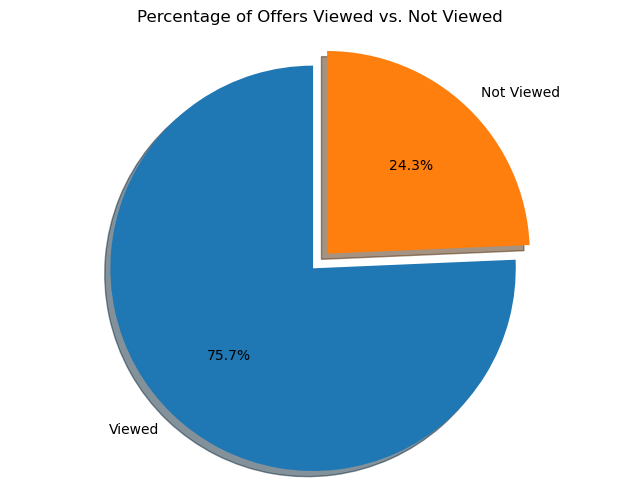

In [29]:
stats = df.groupby('event').size()
received = stats['offer received']
viewed = stats['offer viewed']
pct_viewed = viewed/received

print('Total Offers Recieved:', received)
print('Total Offers Viewed:', viewed)

labels = ['Viewed', 'Not Viewed']
sizes = [viewed, received - viewed]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')

plt.title('Percentage of Offers Viewed vs. Not Viewed')
plt.show()

**What channels of communication were used?**<br>
There were four communication channels used to sent out offers.

1. web
2. email
3. mobile
4. social

Each offer was sent using two or more of these channels. This makes it difficult for analysis because we don't know which specific channel someone viewed the offer in. However, we still can analyze the effectiveness of those that included or excluded certain channels.

Key takeaways:
- There were only four combination of channels used
- Email was used in all of the channels; Mobile was used in all except 1
- Four of the offers used all 4 channels
- Social was the lowest used channel at 6/10 offers

channels
['email', 'mobile', 'social']           2
['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['web', 'email']                        1
dtype: int64


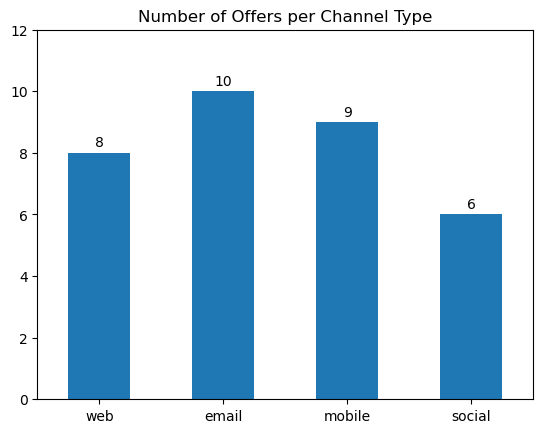

In [30]:
print(offers.groupby('channels').size())

channel_counts = offers[['web', 'email', 'mobile', 'social']].sum()
ax = channel_counts.plot(kind='bar')
plt.title('Number of Offers per Channel Type')
plt.ylim(0,12)
plt.xticks(rotation=0)

# Add data labels
for i, value in enumerate(channel_counts):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

**What is the view rate per channel?**<br>
Social had the highest view rate of 93%, while web and social had lower view rate around 75%.<br>
This suggests Social may be a factor in the offer view rate

Channel: web
Received: 61001
Viewed: 44322
Viewed %: 0.7265782528155276


Channel: email
Received: 76277
Viewed: 57725
Viewed %: 0.7567812053436815


Channel: mobile
Received: 68609
Viewed: 55062
Viewed %: 0.802547770700637


Channel: social
Received: 45683
Viewed: 42629
Viewed %: 0.9331479981612416




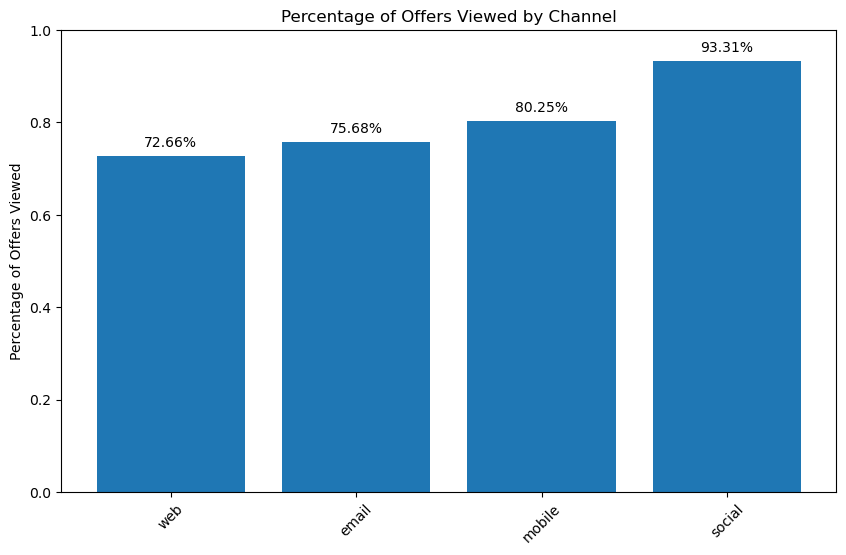

In [35]:
def view_pct(channel, df):
    df = df[df[channel]==1]
    stats = df.groupby(['event']).size()
    received = stats['offer received']
    viewed = stats['offer viewed']
    pct_viewed = viewed/received
    print('Channel:', channel)
    print('Received:', received)
    print('Viewed:', viewed)
    print('Viewed %:', pct_viewed)
    print('\n')
    return pct_viewed

web_pct = view_pct('web', df)
email_pct = view_pct('email', df)
mobile_pct = view_pct('mobile', df)
social_pct = view_pct('social', df)

percentages = [web_pct, email_pct, mobile_pct, social_pct]
labels = ['web','email','mobile','social']
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages)
plt.ylabel('Percentage of Offers Viewed')
plt.title('Percentage of Offers Viewed by Channel')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# add data labels
for i, v in enumerate(percentages):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.show()

**What is the view rate for each offer?**<br>

- Each offer sent out about the same number of offers to customers.
- Offer B,G,D,F had a view rate of 96% and used all 4 communication channels
- Only 8% less offers were viewed when not using the Web channel (offer J)
- 42% less offers were viewed when not using the Social channel, again suggesting Social is a key factor
- Offer E had the lowest view rate of 35% and only used Web and Email channels.

  alias                              channels
0     A         ['email', 'mobile', 'social']
1     B  ['web', 'email', 'mobile', 'social']
2     C            ['web', 'email', 'mobile']
3     D  ['web', 'email', 'mobile', 'social']
4     E                      ['web', 'email']
5     F  ['web', 'email', 'mobile', 'social']
6     G  ['web', 'email', 'mobile', 'social']
7     H            ['web', 'email', 'mobile']
8     I            ['web', 'email', 'mobile']
9     J         ['email', 'mobile', 'social']
event  offer received  offer viewed  offer completed  view rate
offer                                                          
E              7668.0        2663.0           3420.0       35.0
C              7677.0        4171.0           4354.0       54.0
H              7632.0        4118.0           4017.0       54.0
I              7617.0        4144.0              NaN       54.0
A              7658.0        6716.0           3688.0       88.0
J              7618.0        6687.0           

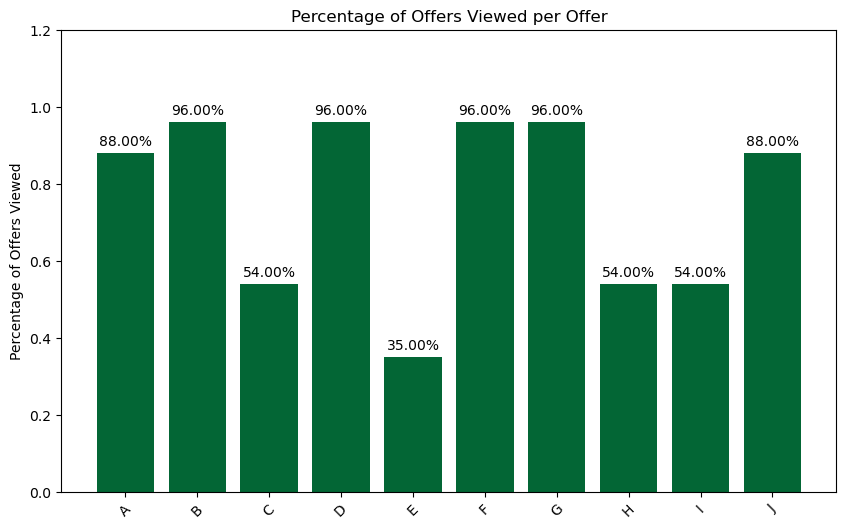

In [86]:
# print offer channels
print(offers[['alias', 'channels']])


# view rate per offer
pivot = events.groupby(['offer','event']).size().unstack()
pivot = pivot[['offer received', 'offer viewed','offer completed']]
pivot['view rate'] = round(pivot['offer viewed']/pivot['offer received'] * 100,0)
print(pivot.sort_values(by='view rate', ascending=True))

percentages = pivot['view rate'] * 1/100
labels = pivot.index
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages,  color='#036635')
plt.ylabel('Percentage of Offers Viewed')
plt.title('Percentage of Offers Viewed per Offer')
plt.ylim(0, 1.2)
plt.xticks(rotation=45)

# add data labels
for i, v in enumerate(percentages):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center')


**What is the customer demographic?**<br>

- Average customer age is 54 years old
- Average customer income is $65,404
- Large increase in memberships right before 2018 and slow decline since

# of customers: 14825
                age         income
count  14825.000000   14825.000000
mean      54.393524   65404.991568
std       17.383705   21598.299410
min       18.000000   30000.000000
25%       42.000000   49000.000000
50%       55.000000   64000.000000
75%       66.000000   80000.000000
max      101.000000  120000.000000


/var/folders/p3/dqqbfzkd0ln207r8z90_jbnc0000gp/T/ipykernel_87678/941183682.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='Greens_d')


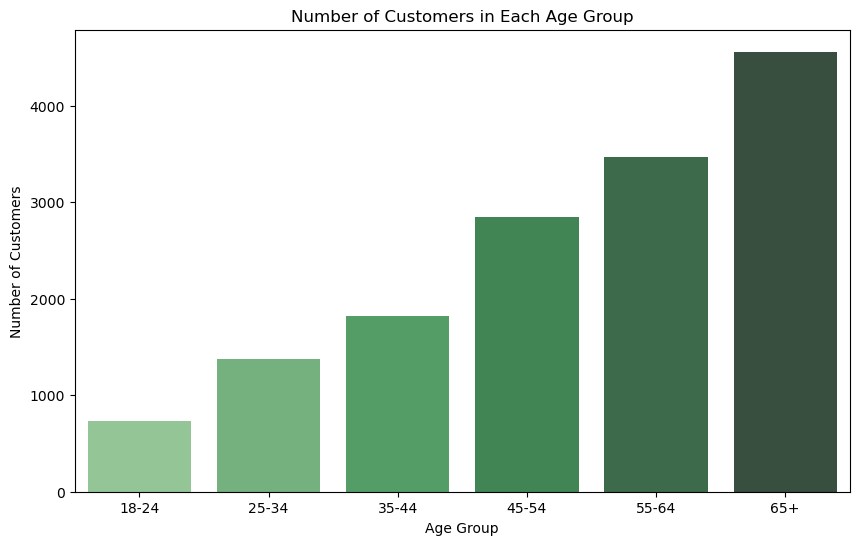

/var/folders/p3/dqqbfzkd0ln207r8z90_jbnc0000gp/T/ipykernel_87678/941183682.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_group_counts.index, y=income_group_counts.values, palette='Greens_d')


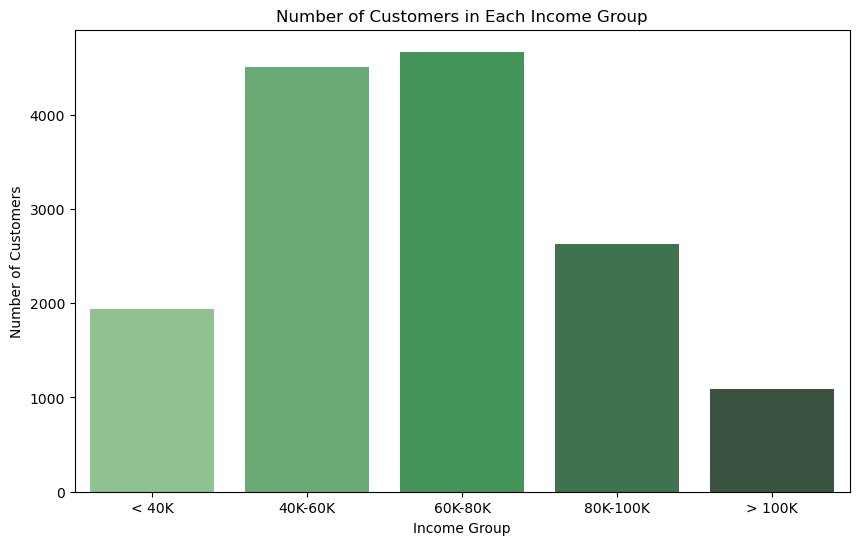

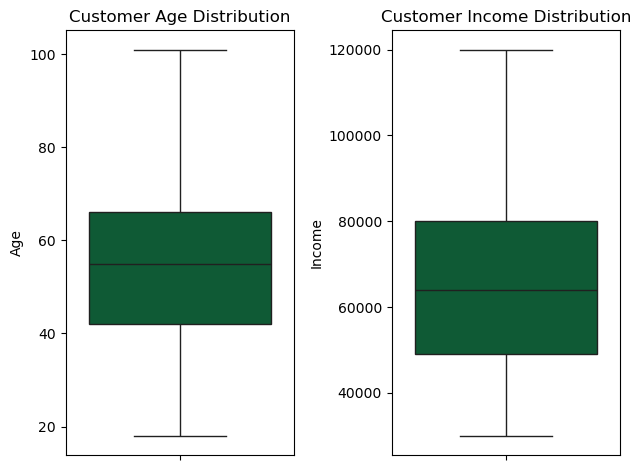

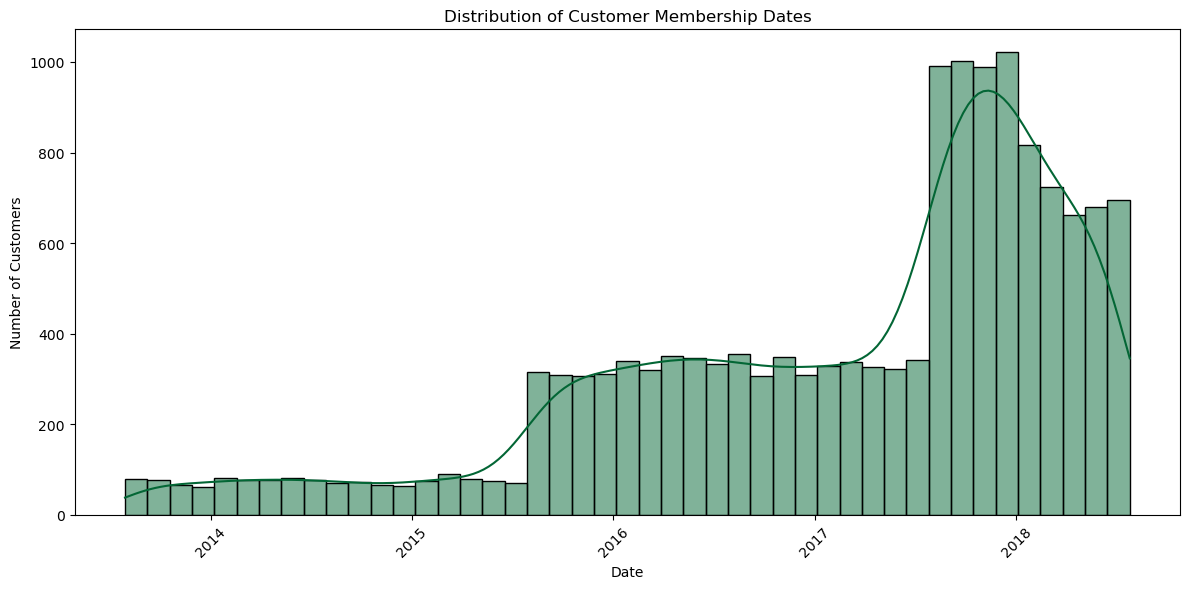

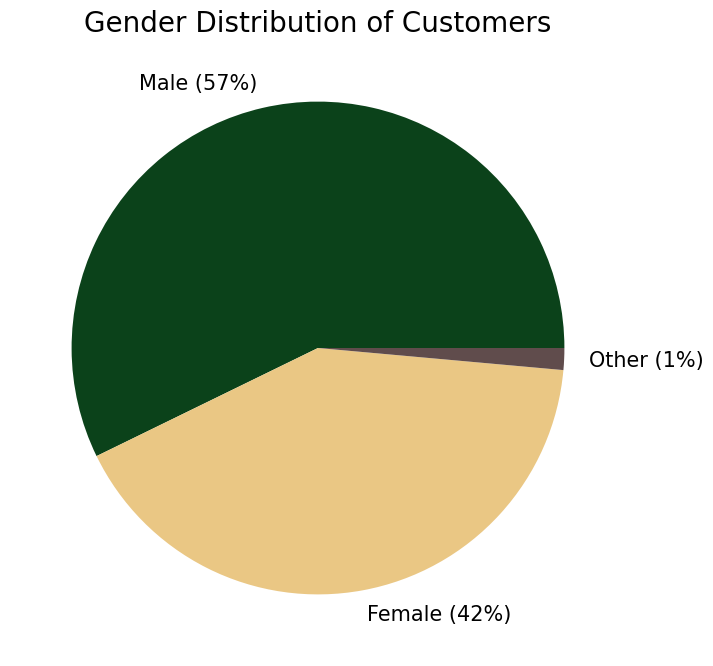

In [123]:
print('# of customers:', len(customers))
print(customers[['age','income']].describe())

# age group bar plot
age_group_counts = customers['age_group'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='Greens_d')
plt.title('Number of Customers in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.show()

# income group bar plot
income_group_counts = customers['income_group'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=income_group_counts.index, y=income_group_counts.values, palette='Greens_d')
plt.title('Number of Customers in Each Income Group')
plt.xlabel('Income Group')
plt.ylabel('Number of Customers')
plt.show()


# Boxplot for Age
plt.subplot(1, 2, 1)
sns.boxplot(y=customers['age'], color='#036635')
plt.title('Customer Age Distribution')
plt.ylabel('Age')

# Boxplot for Income
plt.subplot(1, 2, 2)
sns.boxplot(y=customers['income'], color='#036635')
plt.title('Customer Income Distribution')
plt.ylabel('Income')

plt.tight_layout()
plt.show()


# Plot the distribution of membership dates
plt.figure(figsize=(12, 6))
sns.histplot(customers['became_member_on'], bins=45, kde=True, color='#036635')

plt.title('Distribution of Customer Membership Dates')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart for Gender
gender_counts = customers['gender'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=['Male (57%)','Female (42%)','Other (1%)'],
       textprops={'fontsize': 15}, colors=['#0B421A', '#EAC784', '#604C4C'])
plt.title('Gender Distribution of Customers', fontsize = 20)
plt.show()

**What is the customer view rate?**<br>

- Average customer age is 54 years old
- Average customer income is $65,404
- Large increase in memberships right before 2018 and slow decline since

In [162]:
def view_rate_analysis(feature, title):
    pivot = df.groupby([feature,'event']).size().unstack()
    pivot['view rate'] = pivot['offer viewed'] / pivot['offer received']
    print(pivot)

    pivot = pivot.reset_index()

    # Create a bar plot for gender and view rate
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature, y='view rate', data=pivot, palette='Greens', )

    # Add titles and labels
    plt.title(title, fontsize = 15)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])
    plt.ylim(0, 1.2)
    plt.xticks(fontsize=18)

    # add data labels
    for i, v in enumerate(pivot['view rate']):
        plt.text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize = 15)

    # Display the plot
    plt.show()

**Gender**<br>
Doesn't seem to be an difference in view rate per gender

event   offer completed  offer received  offer viewed  transaction  view rate
gender                                                                       
F                 15477           27456         20786        49382   0.757066
M                 16466           38129         28301        72794   0.742243
O                   501             916           773         1781   0.843886


/var/folders/p3/dqqbfzkd0ln207r8z90_jbnc0000gp/T/ipykernel_87678/2426543748.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='view rate', data=pivot, palette='Greens', )


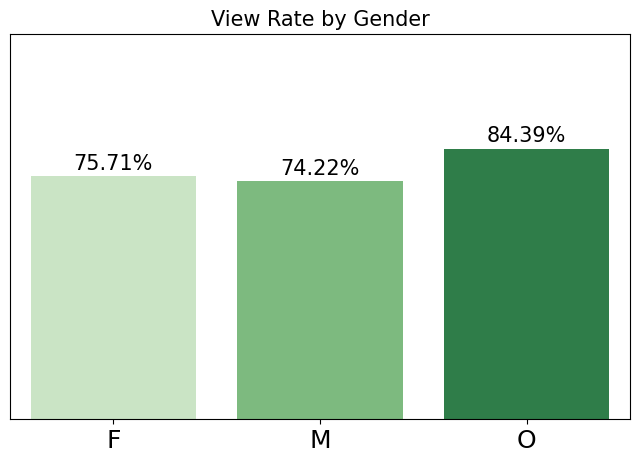

In [163]:
view_rate_analysis('gender', 'View Rate by Gender')

**Income**<br>
Doesn't seem to be an difference in view rate per income

event         offer completed  offer received  offer viewed  transaction  \
income_group                                                               
< 40K                    3049            8774          6008        19754   
40K-60K                  8516           20201         14970        42068   
60K-80K                 10673           20887         16178        38787   
80K-100K                 7141           11721          9400        16696   
> 100K                   3065            4918          3304         6652   

event         view rate  
income_group             
< 40K          0.684750  
40K-60K        0.741052  
60K-80K        0.774549  
80K-100K       0.801979  
> 100K         0.671818  


/var/folders/p3/dqqbfzkd0ln207r8z90_jbnc0000gp/T/ipykernel_87678/2426543748.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df.groupby([feature,'event']).size().unstack()
/var/folders/p3/dqqbfzkd0ln207r8z90_jbnc0000gp/T/ipykernel_87678/2426543748.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='view rate', data=pivot, palette='Greens', )


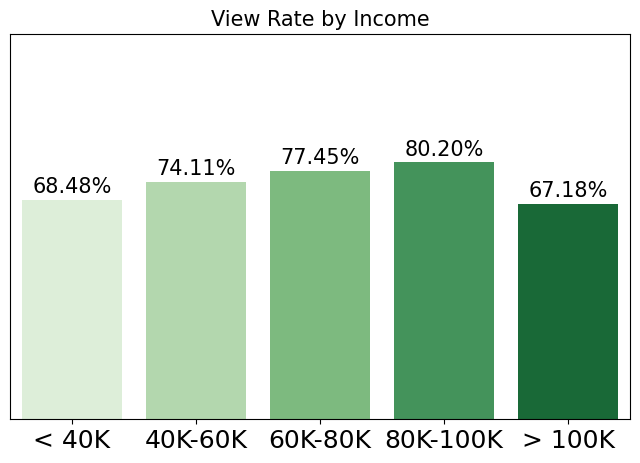

In [164]:
view_rate_analysis('income_group', 'View Rate by Income')

**Age**<br>
Doesn't seem to be an difference in view rate per age

In [ ]:
view_rate_analysis('age_group', 'View Rate by Age')

### 4. Advanced Ananlytics

To determine the likelihood of an offer being viewed by a customer, we can analyze whether each offer sent was viewed. By examining this data, we can identify factors, such as customer demographics and communication channels, that influence the probability of offer engagement.

In [214]:
# each offer viewed per person
viewed = df[df['event']=='offer viewed']
viewed = viewed[['person','offer']].drop_duplicates()
viewed['viewed'] = 1

# each offer sent to a person and whether it was viewed
model_df = df[df['event']=='offer received']
model_df = model_df[['person','offer','channels', 'web', 'email', 'mobile', 'social', 'gender', 'age_group', 'income_group', 'membership_months_group']]
model_df = model_df[~model_df['gender'].isna()] # filter customer we filtered out
model_df = model_df.drop_duplicates() # only unique person and offer
model_df = model_df.merge(viewed, on=['person', 'offer'], how='left')
model_df['viewed'] = model_df['viewed'].fillna(0)
model_df.head(3)

,person,offer,channels,web,email,mobile,social,gender,age_group,income_group,membership_months_group,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,C,"['web', 'email', 'mobile']",1.0,1.0,1.0,0.0,F,65+,> 100K,10-30 months,1.0
1,e2127556f4f64592b11af22de27a7932,H,"['web', 'email', 'mobile']",1.0,1.0,1.0,0.0,M,65+,60K-80K,< 10 months,1.0
2,389bc3fa690240e798340f5a15918d5c,D,"['web', 'email', 'mobile', 'social']",1.0,1.0,1.0,1.0,M,65+,40K-60K,< 10 months,1.0


A Random Forest Tree Model  was used to predict whether a customer would view the offer based on:
- Channel (web, email, social, mobile)
- Gender
- Age
- Income
- Months they have been a member

In [215]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Scale features and split data
x = model_df.drop(columns=['channels','person', 'offer', 'viewed'])
x = pd.get_dummies(x, drop_first=True)
y = model_df['viewed']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# predict test data
y_pred = model.predict(X_test)

# Evaluate the model
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8206428248076052
              precision    recall  f1-score   support

         0.0       0.62      0.52      0.57      2481
         1.0       0.87      0.91      0.89      8564

    accuracy                           0.82     11045
   macro avg       0.74      0.71      0.73     11045
weighted avg       0.81      0.82      0.81     11045



F1 accuracy score of 0.82

In [217]:
# show feature importances
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

                                 Feature  Importance
3                                 social    0.603883
2                                 mobile    0.167140
13                 income_group_80K-100K    0.040828
0                                    web    0.033018
12                  income_group_60K-80K    0.019080
4                               gender_M    0.017918
15  membership_months_group_10-30 months    0.015459
11                  income_group_40K-60K    0.012880
16  membership_months_group_30-50 months    0.012547
6                        age_group_25-34    0.012228
9                        age_group_55-64    0.010428
7                        age_group_35-44    0.010102
17   membership_months_group_> 50 months    0.009836
8                        age_group_45-54    0.009517
10                         age_group_65+    0.009458
14                   income_group_> 100K    0.008491
5                               gender_O    0.007188
1                                  email    0.


Key Results:
- Social channel had the highest importance by far (0.604), indicating sending offers through social media plays the largest role in whether an offer is viewed.
- Mobile channel had the second highest importance (0.16). As it may not be as impactful as Social, this suggests sending offers through mobile channels does have an effect on whether an offer is viewed.
- Customer Demographics all had a relatively low importance (<0.04). This showed very little evidence that specific demographics view offers at different rates.

### 5. Business Reccommendations

1. Prioritize Social Media
If possible, it is recommended to use all communication channels to reach the largest audience and have the highest view rates. However, due to limitations, I'd reccomend prioritizing social media (as well as mobile) for future offers as they have the largest impact on customer's viewing the offers. 

2. Track Channel-Specific Events
Track data on a customer viewing an offer for each specific channel (ex: How many customers viewed the offer exclusively through email). This will give more insight into how useful channels are and will help make decisions on keepings / investing in specific channels.

3. Further customer demographic analysis for offer successs
Customer demographics seemed to have minimal impact on offer views. I'd recommend further analyzing customer segments to reveal variations in offer success and completion rates, which may help refine targeted promotions for different customer demographics.


### Presentation

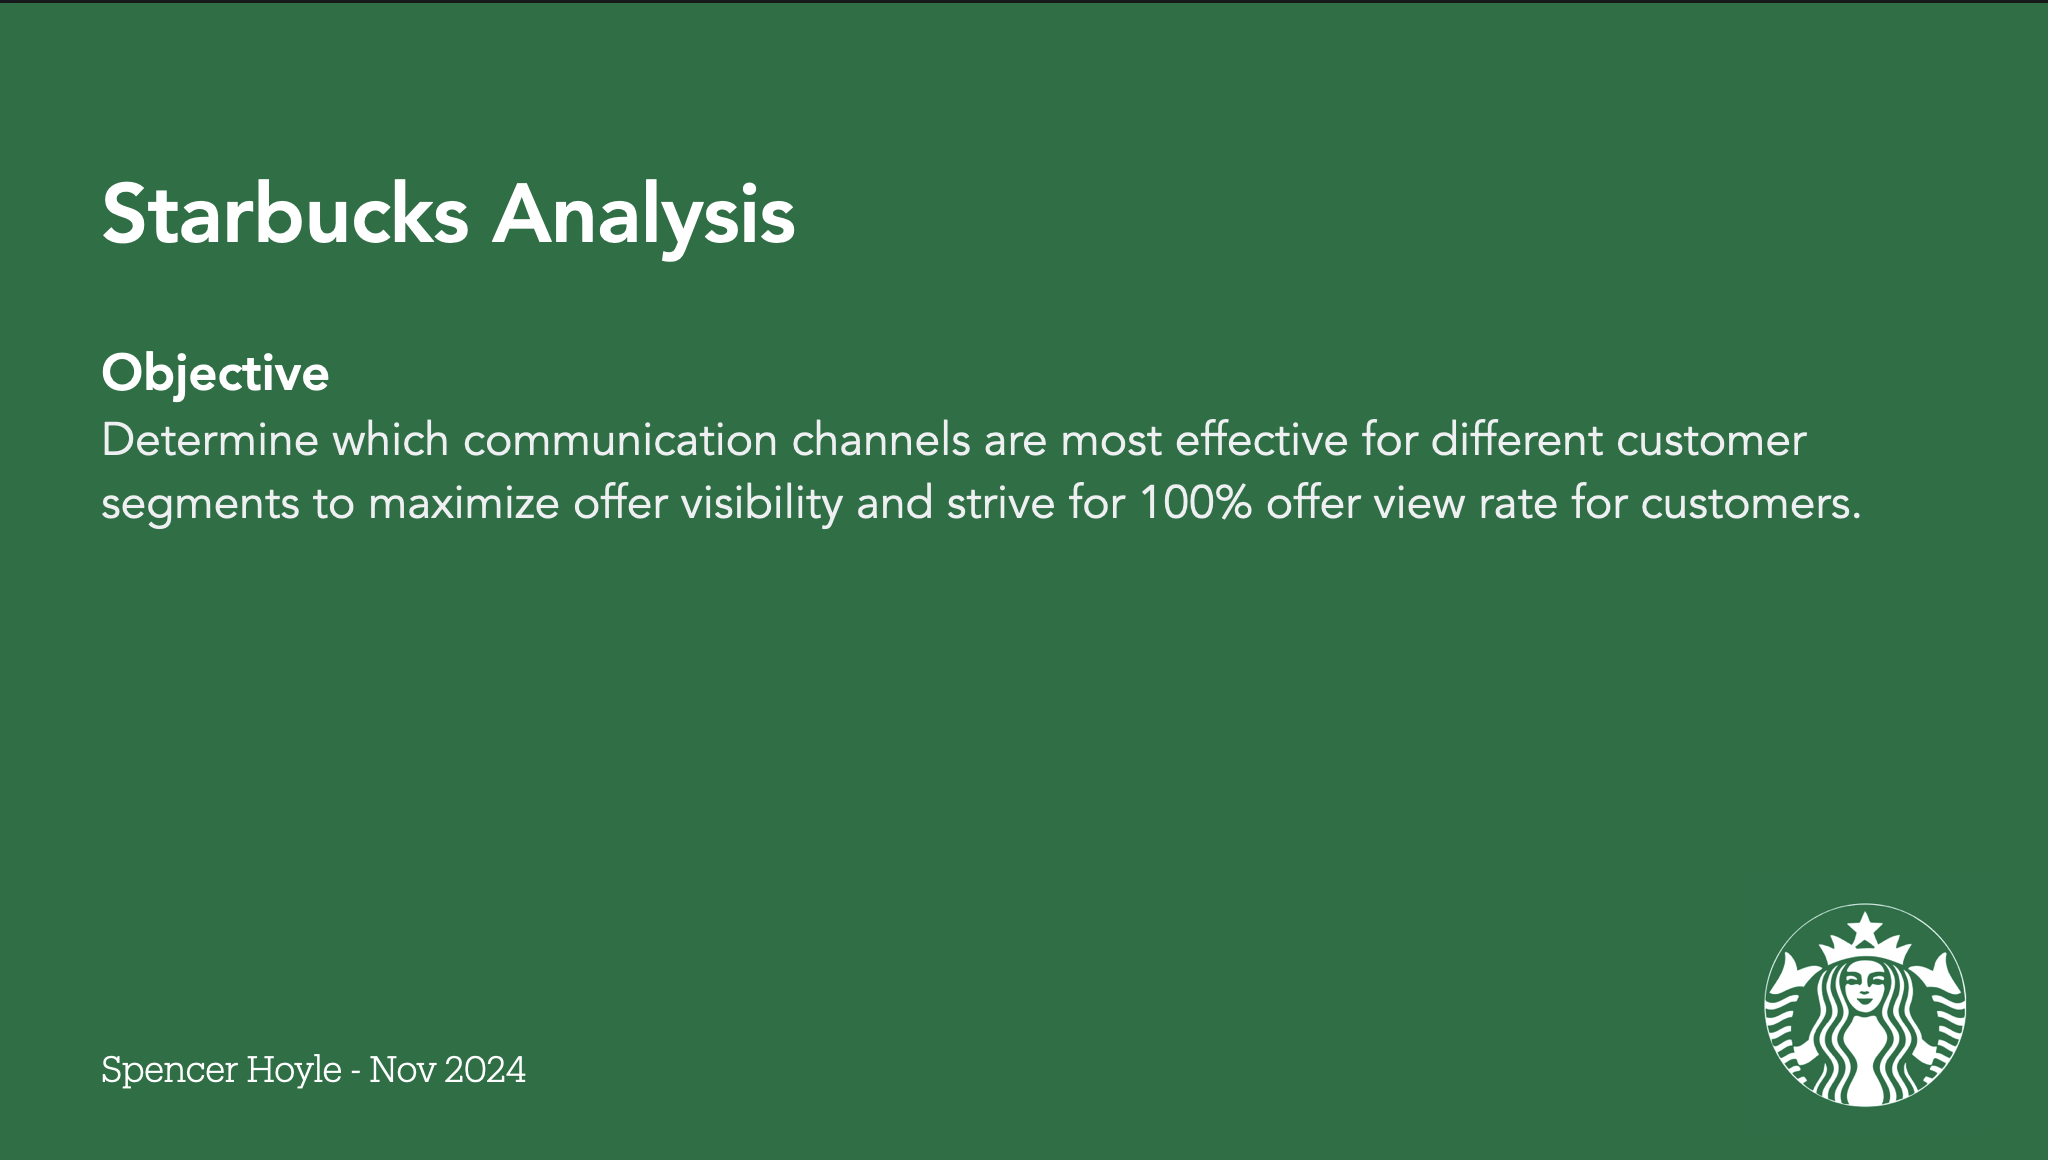
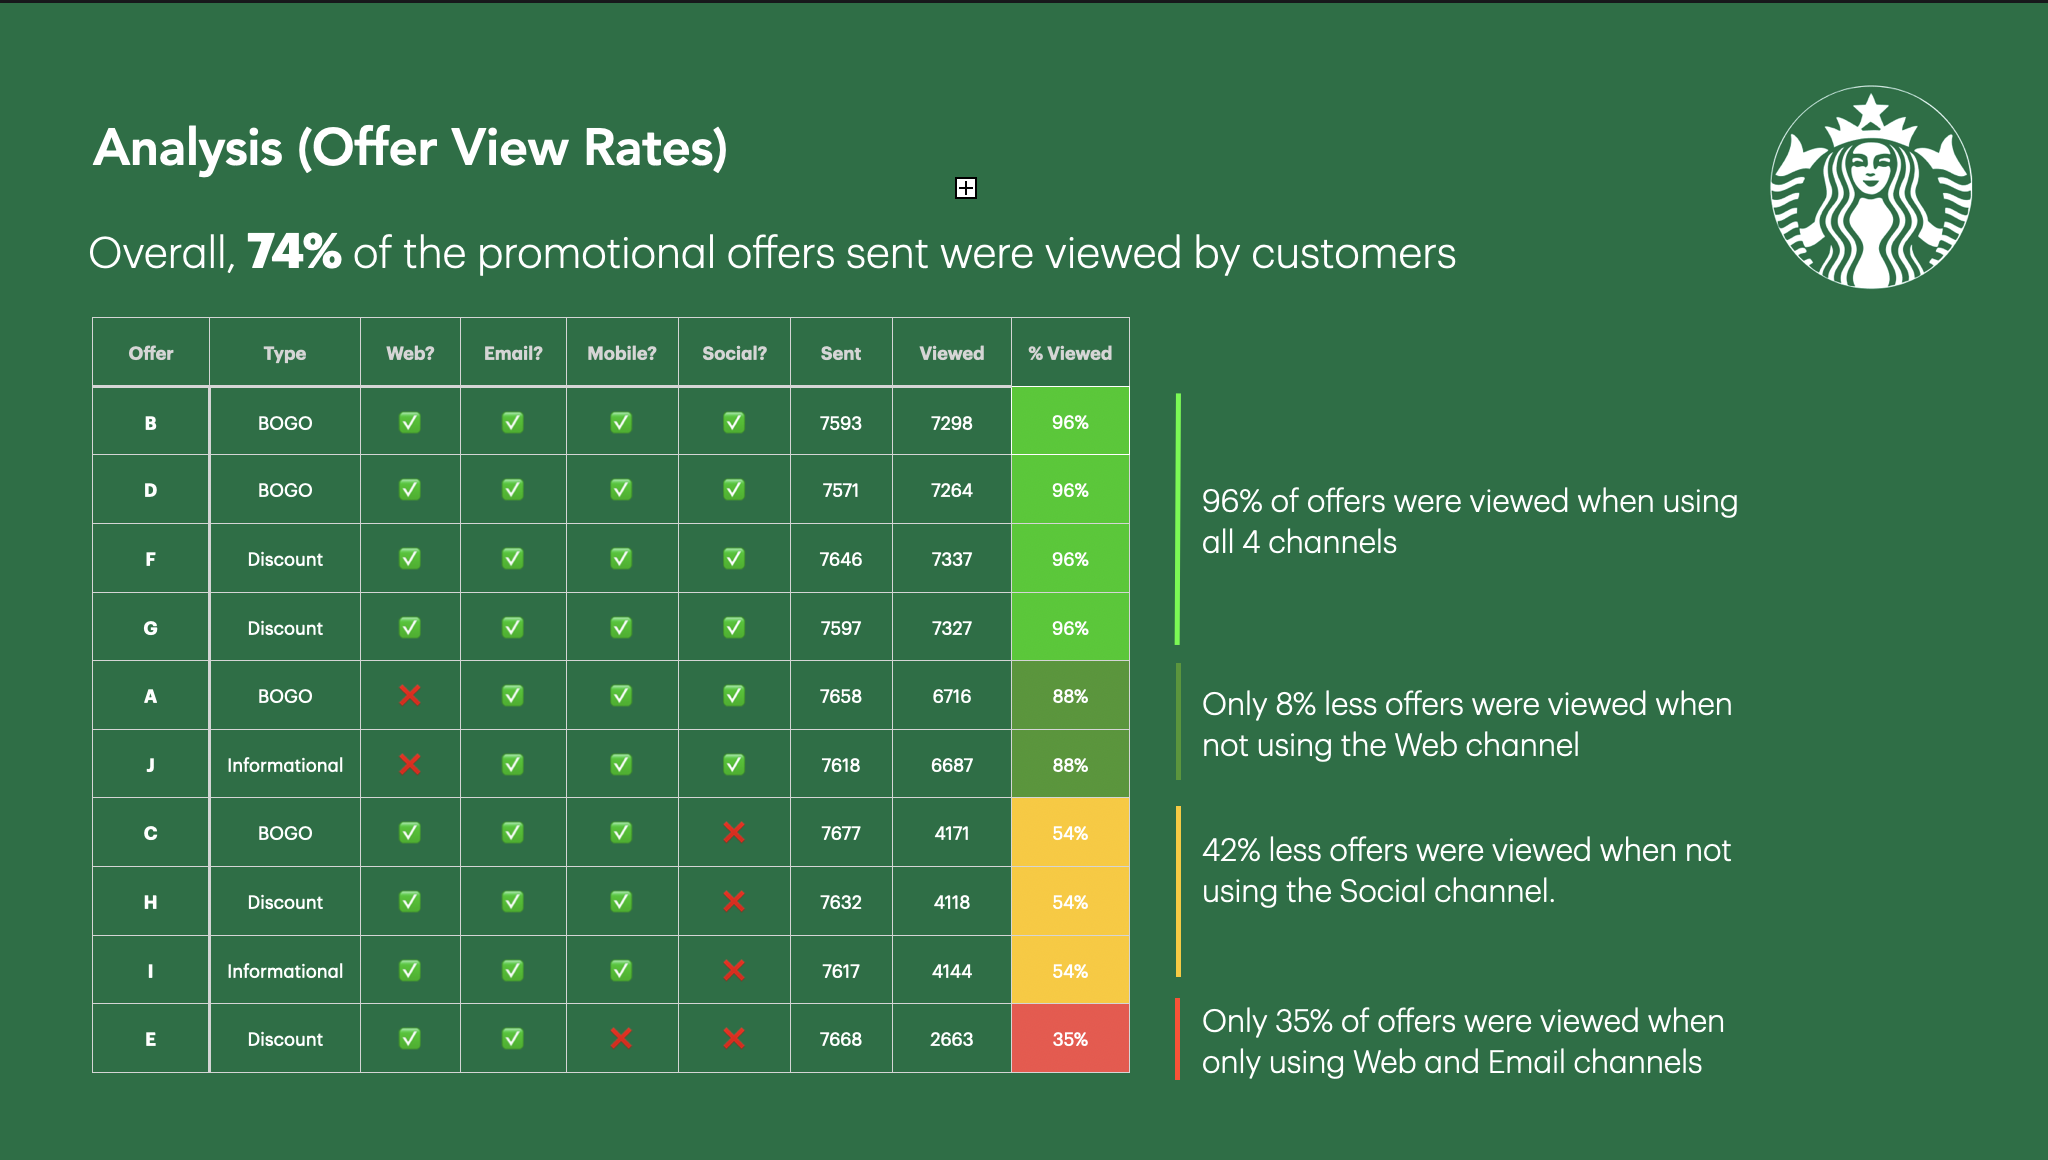
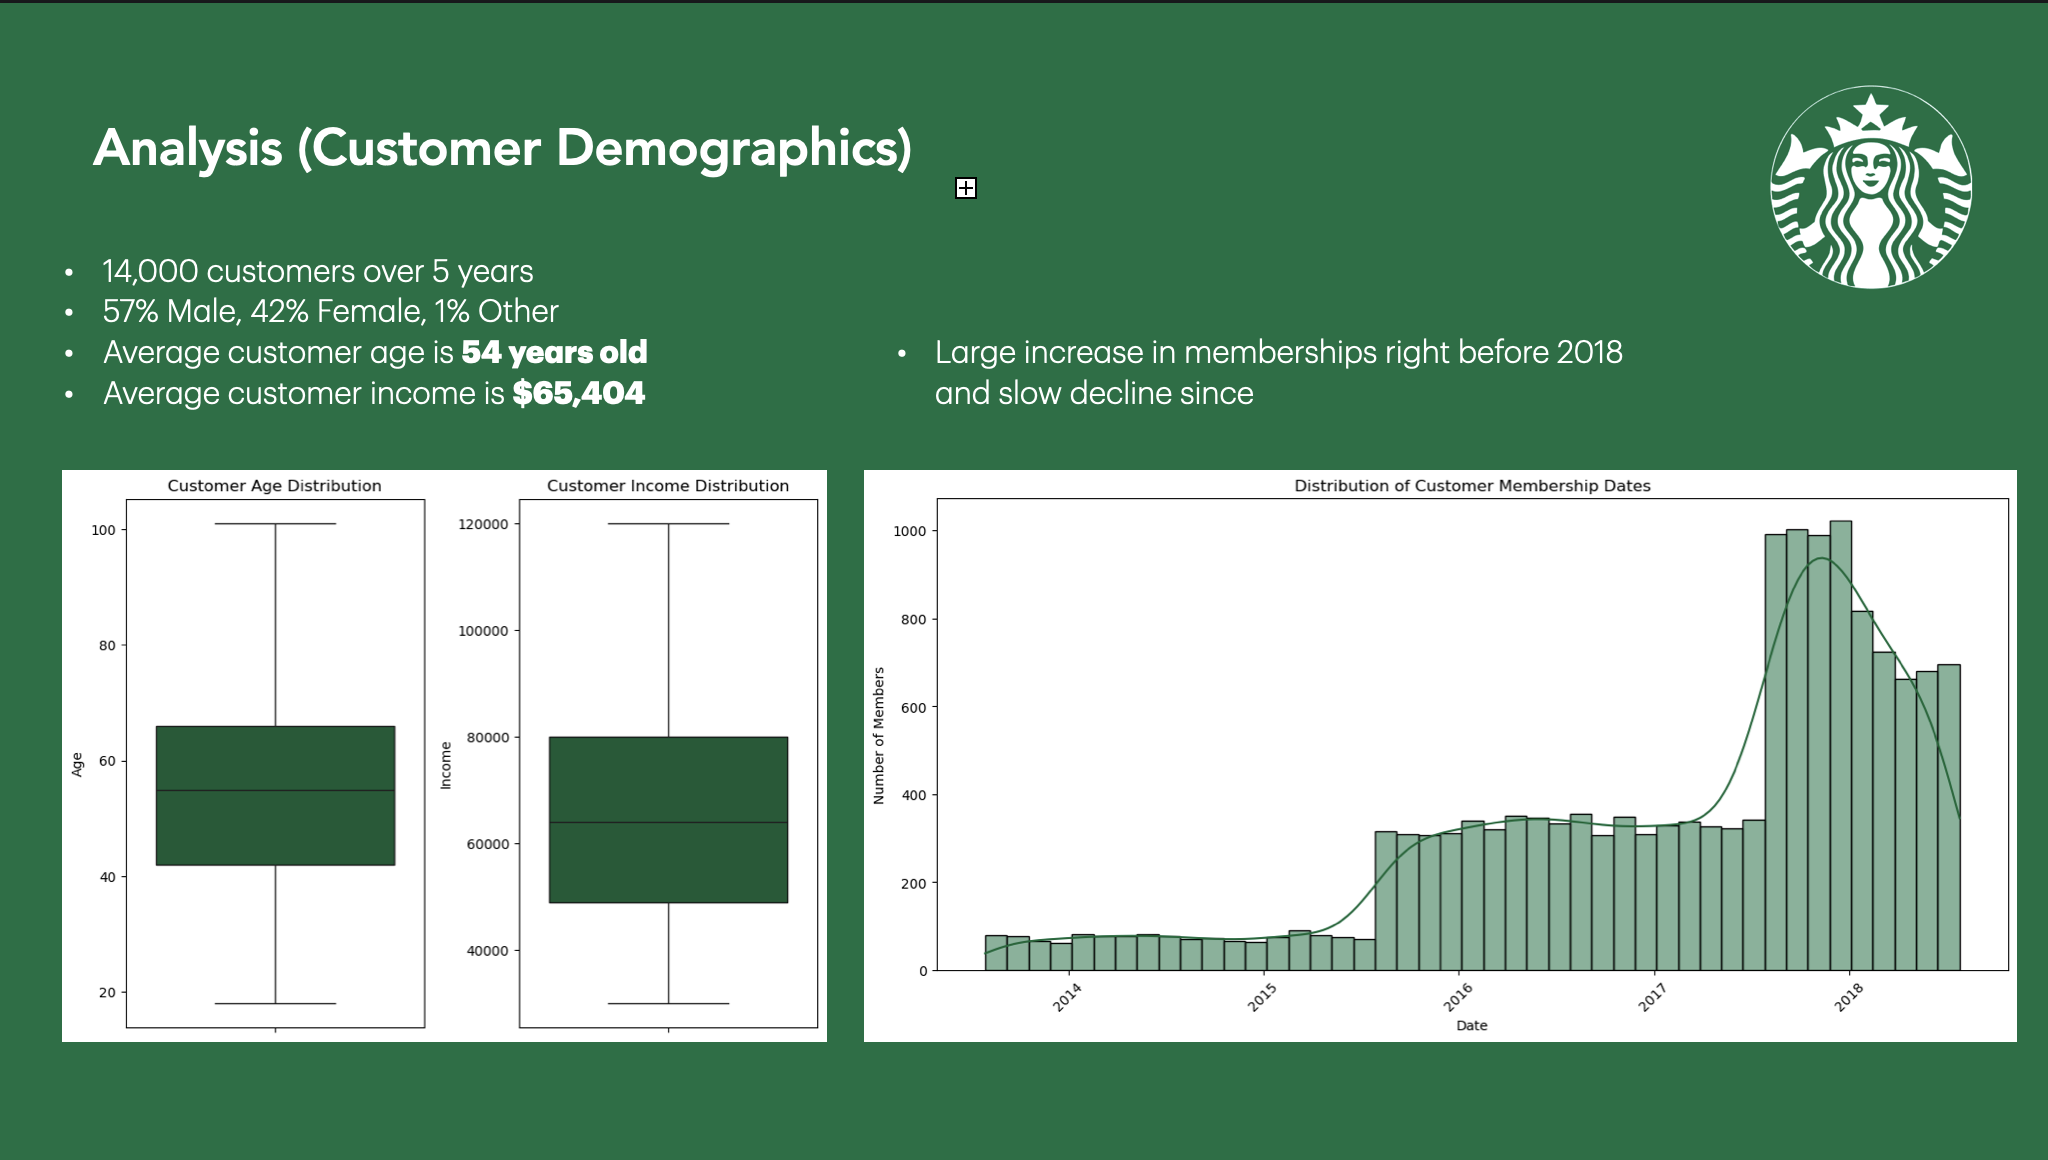
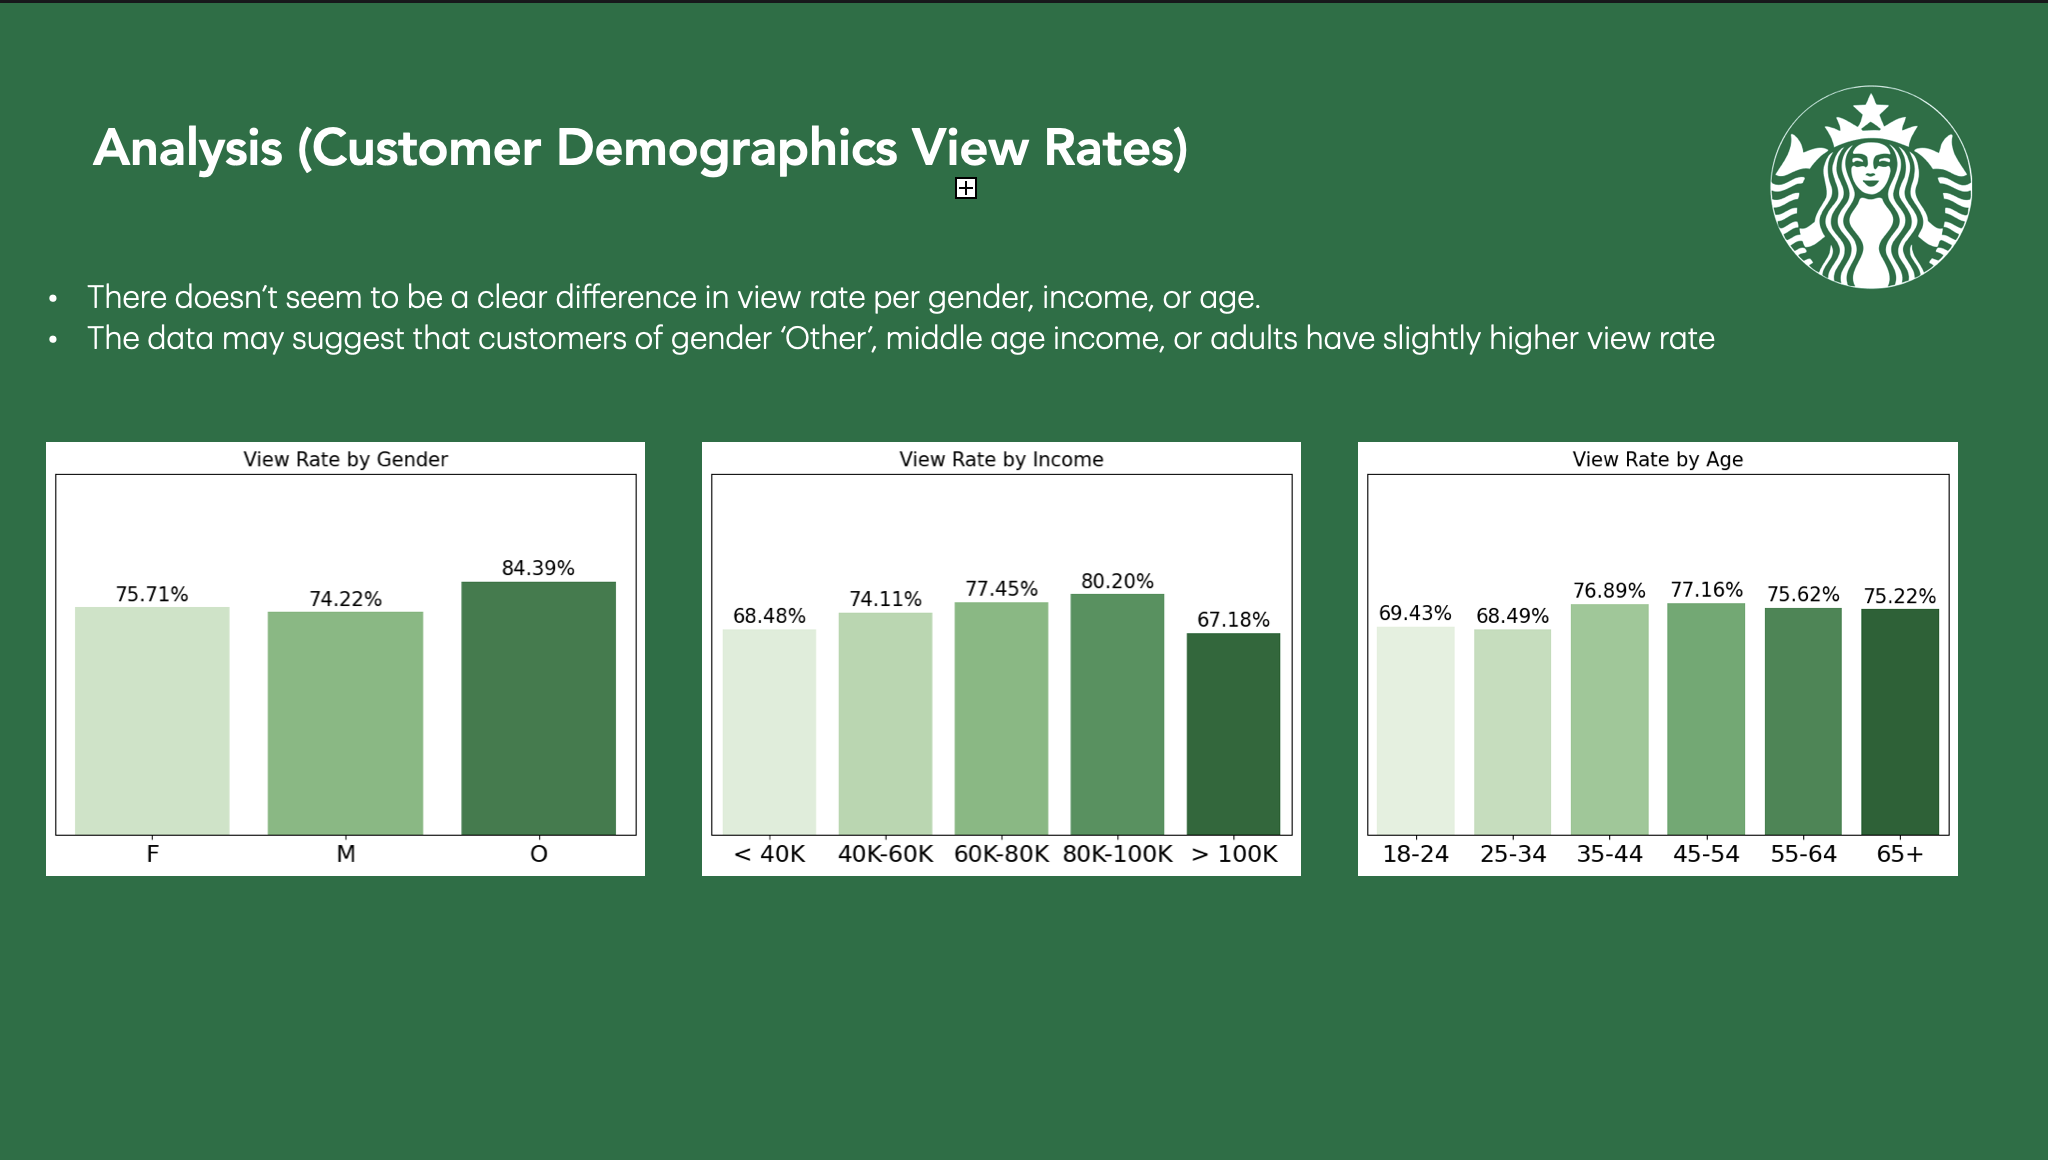
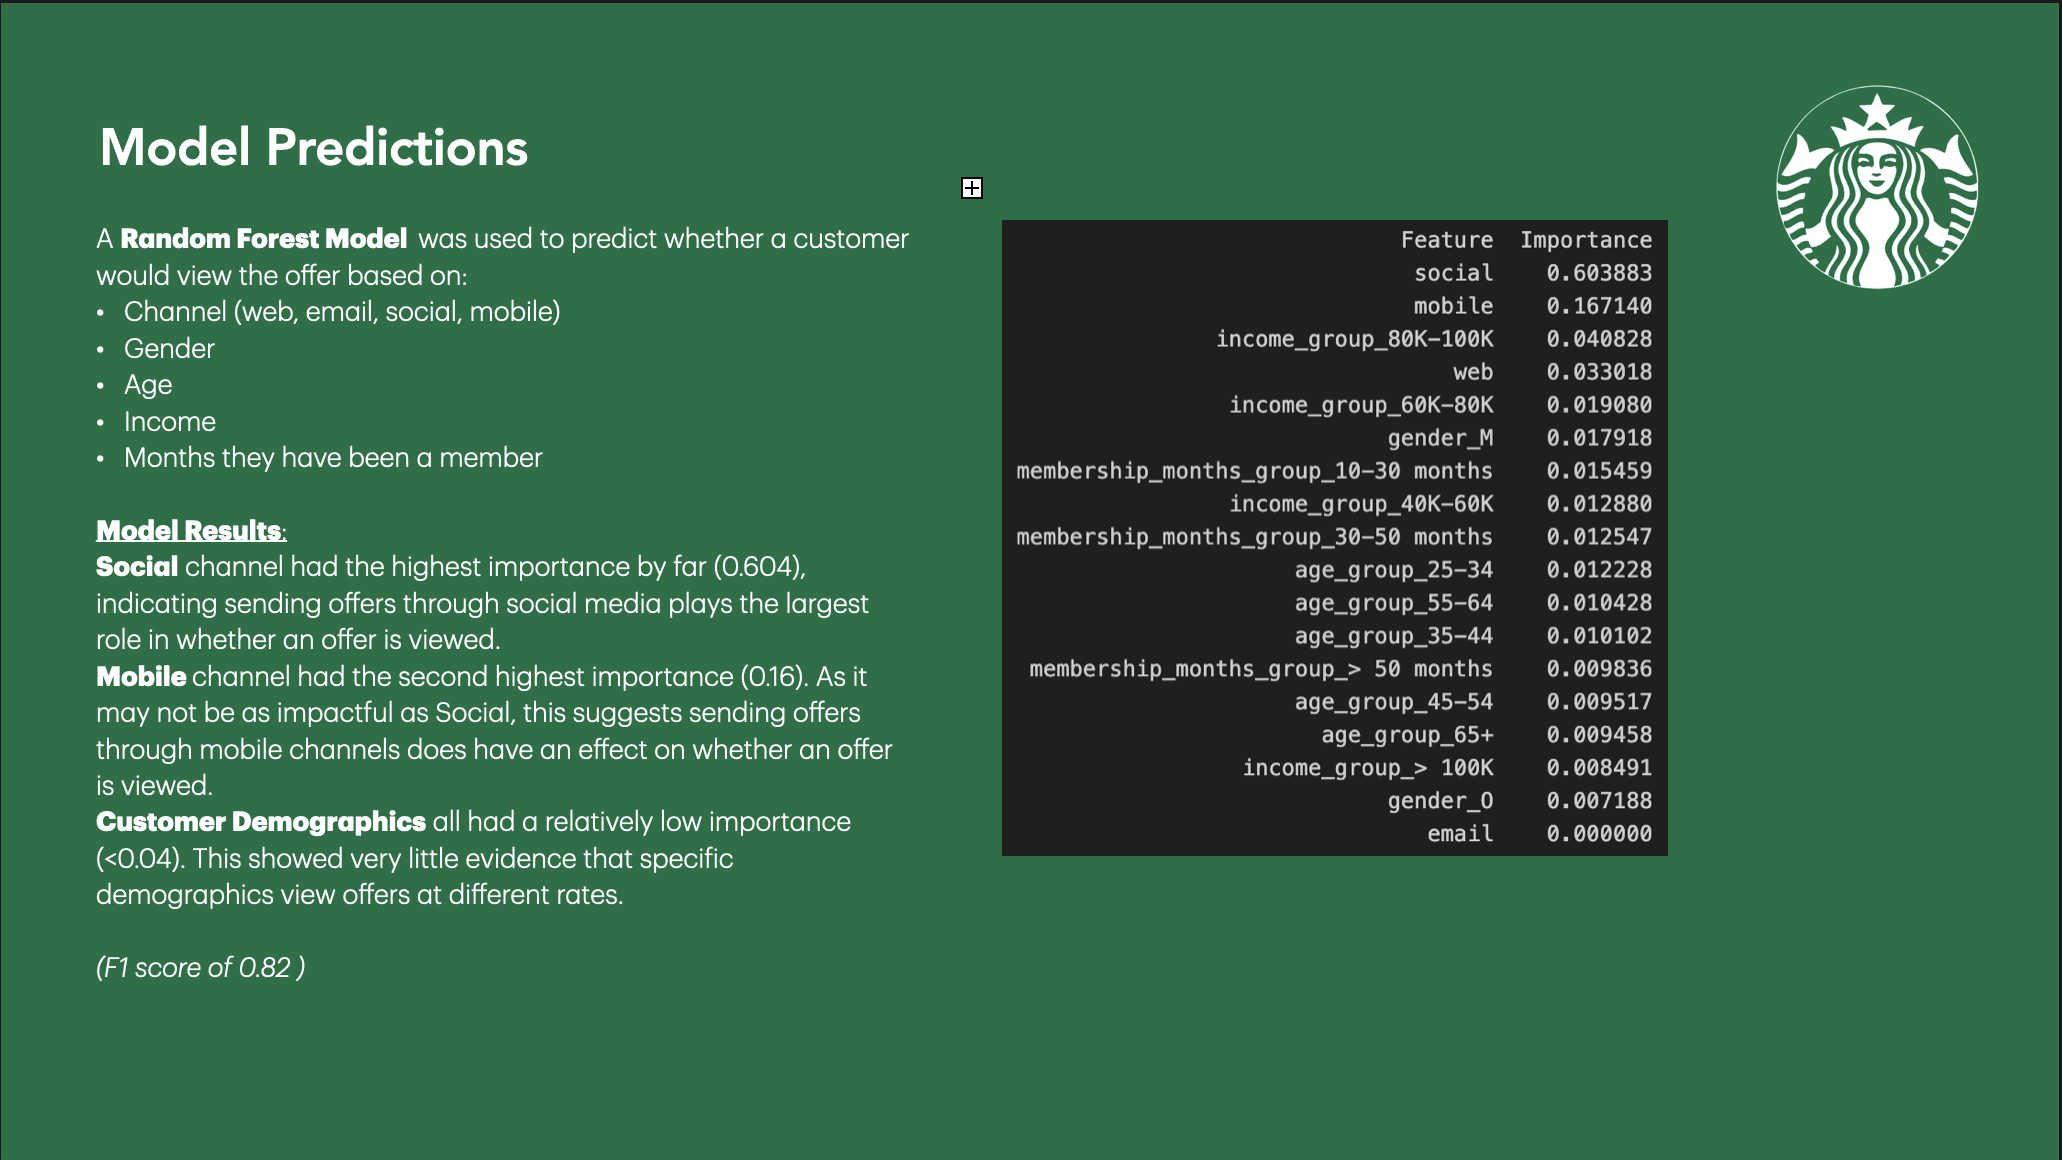
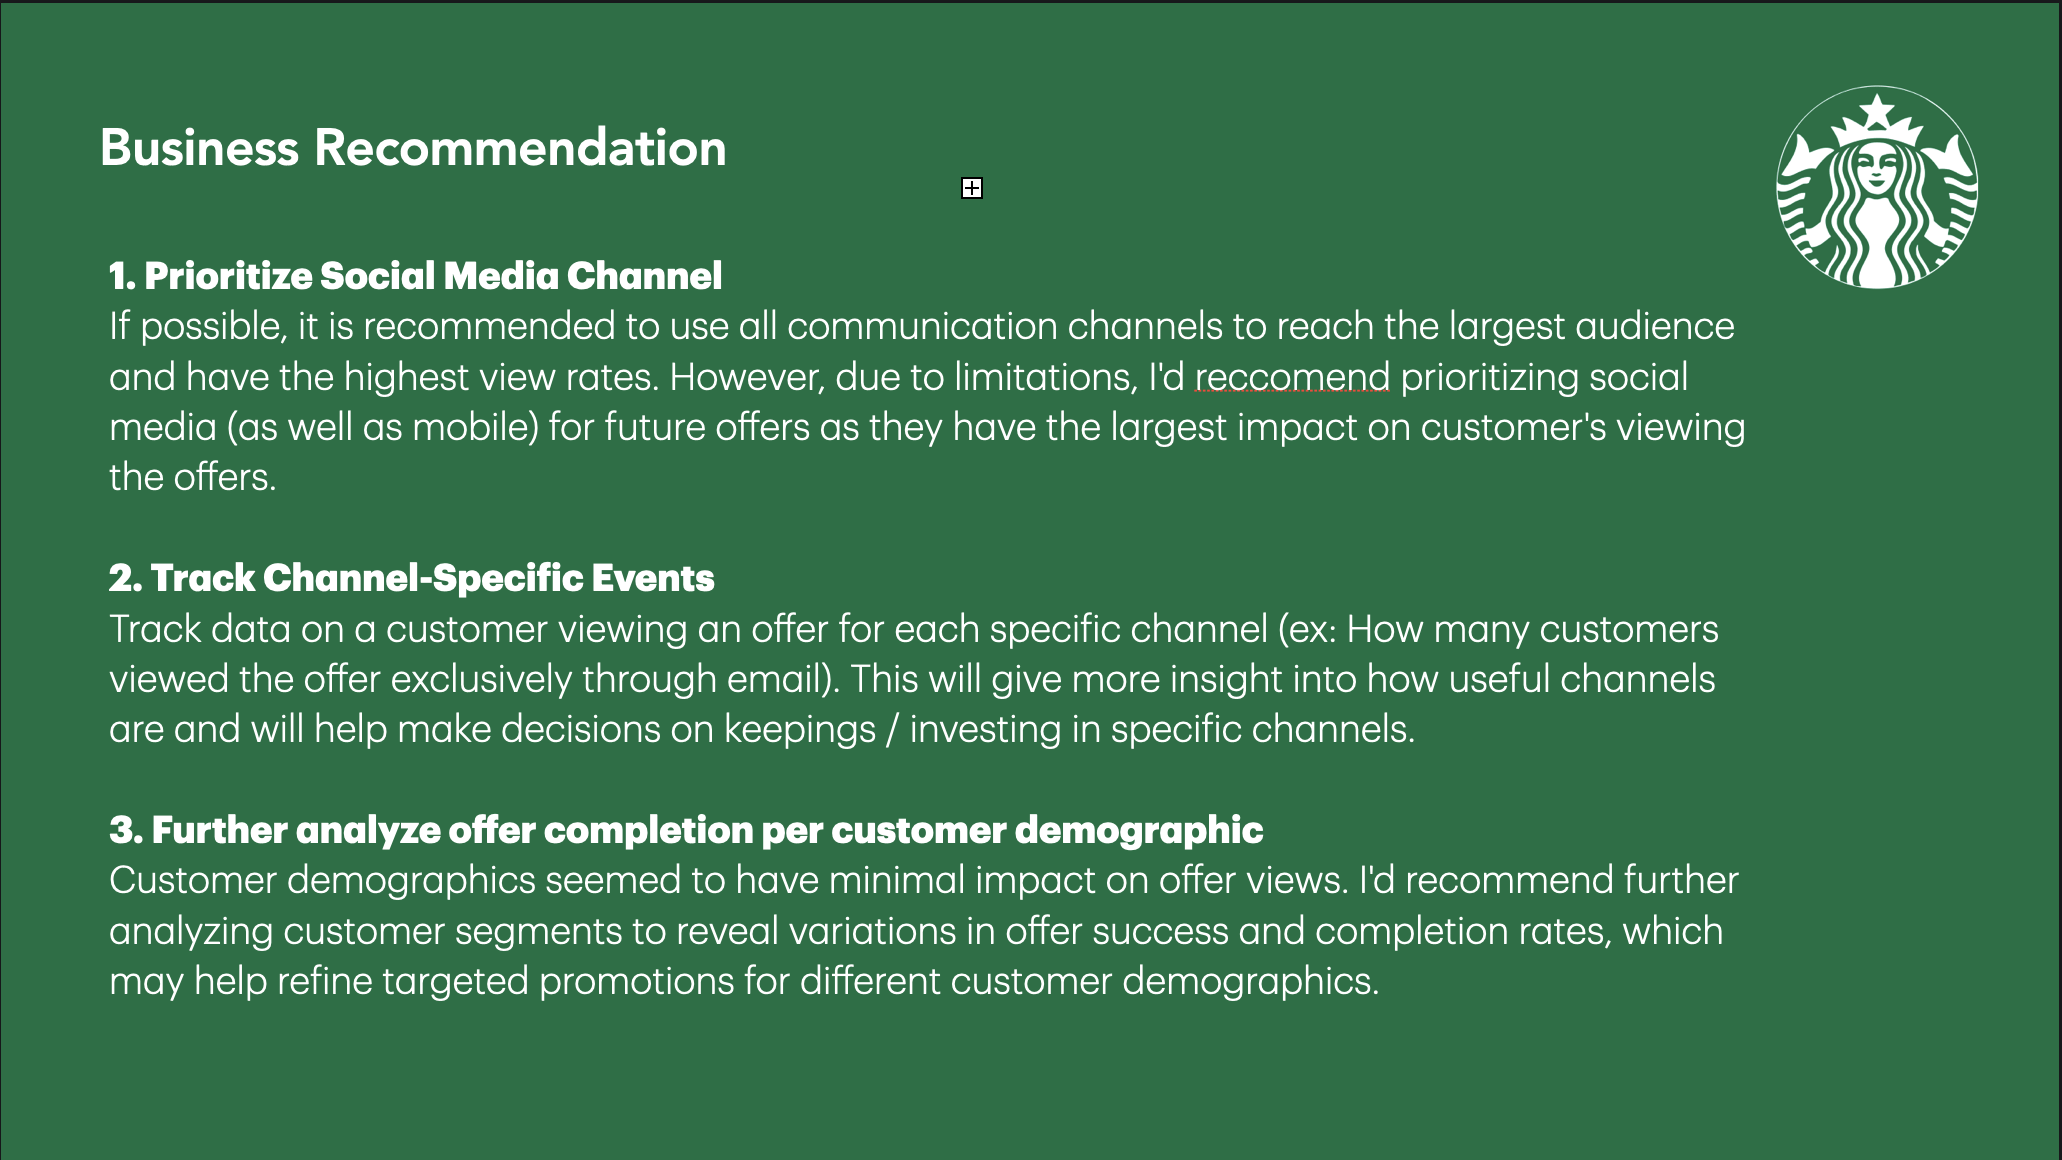